In [555]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from IPython.display import display, Math

In [556]:
KB = c.Boltzmann
hbar = c.Planck

In [557]:
def read_files(dir = 'F:\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set1\\T_100\\'):

    dictionaries = []

    for (i,filename) in enumerate(os.listdir(dir)):
        my_source = dir + filename
        with h5.File(my_source, 'r') as r:
            group = r.require_group(name='raw_data')
            dic = dict()
            for c in group.items():
                dic[c[0]] = c[1][:]
        dictionaries.append(dic)
    return dictionaries

In [558]:
dfs = read_files()

In [559]:
F = dfs[2]['f']
I = dfs[2]['i']
Q = dfs[2]['q']
S21 = np.sqrt(I**2 + Q**2)

Text(0.5, 0, '$\\nu$ [GHz]')

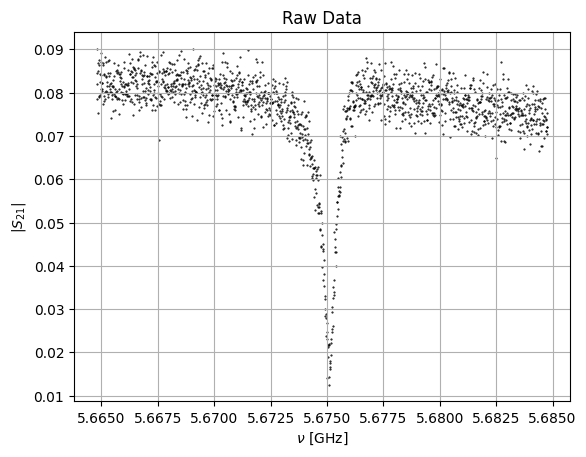

In [567]:
plt.scatter(F/1e9, S21, s=1, marker='.', color='black')
plt.grid()
plt.title("Raw Data")
plt.ylabel("$|S_{21}|$")
plt.xlabel(r"$\nu$ [GHz]")

Find curve peak

In [413]:
x, y = find_peaks(-S21, -0.02)
x_min = F[x[np.argmin(y['peak_heights'])]]
y_min = -max(y['peak_heights'])

Normalize and center data about minimum

In [568]:
S21 = [(x - y_min) / (max(S21) - y_min) for x in S21]
F = (F-x_min)/x_min

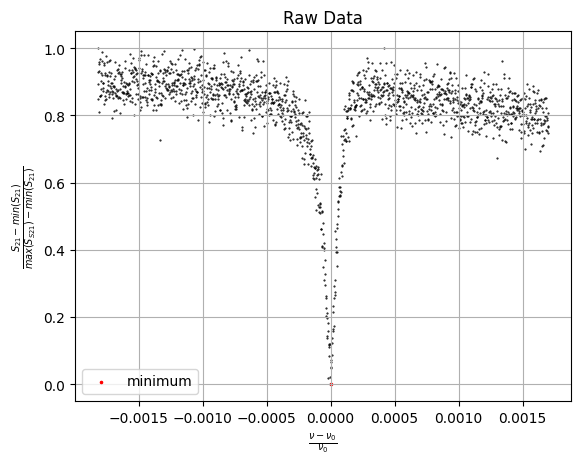

In [570]:
plt.scatter(F, S21, s=1, marker='.', color='black')
plt.scatter(0, min(S21), s=10, marker='.', color='red', label='minimum')
plt.title("Raw Data")
plt.ylabel(r"$\frac{S_{21}-min(S_{21})}{max(S_{S21})-min(S_{21})}$")
plt.xlabel(r"$\frac{\nu-\nu_{0}}{\nu_{0}}$")
plt.legend()
plt.grid()

Separating bg from resonance data + fitting bg with 1st order pol

In [527]:
condition = lambda x: (x<-0.001 or x>0.001)
idxs = [i for i,x in enumerate(F) if condition(x)]
F_bg = np.array([F[i] for i in idxs])
S21_bg = np.array([S21[i] for i in idxs])
F_res = np.array([F[i] for i,x in enumerate(F) if not condition(x)])
S21_res = np.array([S21[i] for i,x in enumerate(F) if not condition(x)])
params = np.polyfit(F, S21,1)
rms = np.sqrt(np.mean((np.polyval(params, F_bg)-S21_bg)**2))

Plot 

Text(0.5, 1.0, 'Background linear fit')

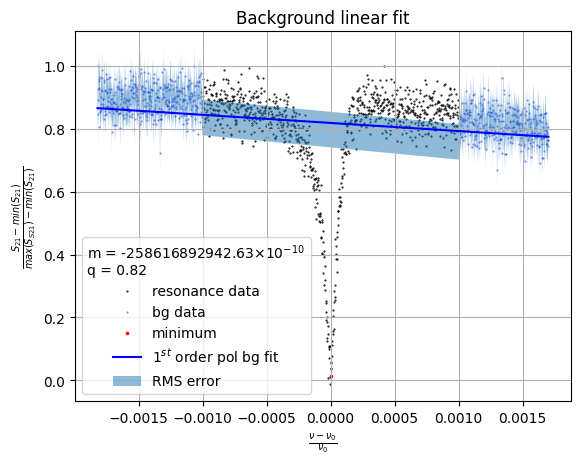

In [571]:
plt.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
plt.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
plt.scatter(0, y_min, s=10, marker='.', color='red', label='minimum')
plt.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
plt.grid()
cond = lambda x: x in F_bg
plt.fill_between(F_bg, S21_bg+rms, S21_bg-rms, alpha=0.5, label='RMS error')
title = [f"m = {params[0]*1e10:.2f}"+r"$\times 10^{-10}$", f"q = {params[1]:.2f}"]
plt.legend(title = "\n".join(title))
plt.ylabel(r"$\frac{S_{21}-min(S_{21})}{max(S_{S21})-min(S_{21})}$")
plt.xlabel(r"$\frac{\nu-\nu_{0}}{\nu_{0}}$")
plt.title("Background linear fit")

Estimate FWHM (using res data only)

In [572]:
def FWHM(x,y):
    max_y = np.max(y)
    half_max_y = max_y / 2.0

    condition = lambda t: (t<=half_max_y*(1+0.01) or t>=half_max_y*(1-0.01))
    indices = [i for i,y in enumerate(y) if condition(y)]
    if len(indices) < 2:
        raise ValueError("Cannot find FWHM. The curve might not cross half of its maximum.")

    # Get corresponding x values
    x_half_max = [x[index] for index in indices]

    # Calculate FWHM
    return np.abs(x_half_max[-1] - x_half_max[0])

Initial parameters estimation

In [618]:
fwhm = FWHM(F_res, S21_res)
Q_tot = x_min/(fwhm*1e9)
Q_c = 3e3
phi0 = -0.1

In [619]:
def resonance_model(x, Q, Qc,phi0):
    return 1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q)))

def model(x, m, q, Q, Qc,phi0):
    par = np.array([m,q])
    pol = np.polyval(par, x)
    res = resonance_model(x, Q,Qc,phi0)
    return np.abs(res)*pol

Text(0.5, 1.0, 'Model with initial parameters')

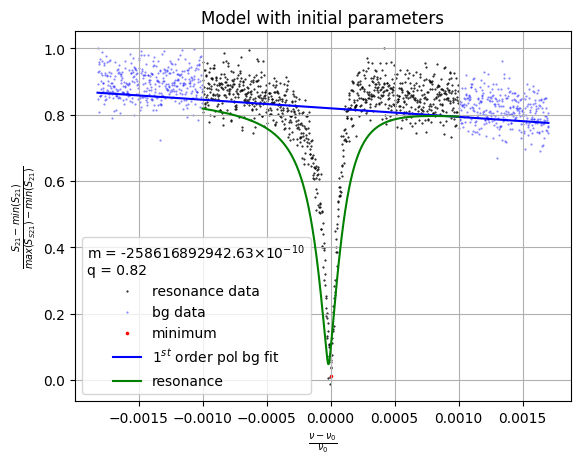

In [620]:
plt.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
plt.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
plt.scatter(0, y_min, s=10, marker='.', color='red', label='minimum')
plt.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
plt.plot(F_res, model(F_res, params[0], params[1], Q_tot, Q_c, phi0), color='green',label='resonance')
plt.grid()
title = [f"m = {params[0]*1e10:.2f}"+r"$\times 10^{-10}$", f"q = {params[1]:.2f}"]
plt.legend(title = "\n".join(title))
plt.ylabel(r"$\frac{S_{21}-min(S_{21})}{max(S_{S21})-min(S_{21})}$")
plt.xlabel(r"$\frac{\nu-\nu_{0}}{\nu_{0}}$")
plt.title("Model with initial parameters")

In [621]:
p0 = [params[0], params[1], Q_tot, Q_c,phi0]
lsq = cost.LeastSquares(F_res,S21_res, rms, model)
m = Minuit(lsq, *p0)

In [622]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 644.2 (χ²/ndof = 0.7)      │              Nfcn = 192              │
│ EDM = 0.000101 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │    -22    │     4     │            │            │         │         │       │
│ 1 │ q    │  0.8708   │  0.0023   │            │            │         │         │       │
│ 2 │ Q    │  5.35e3   │  0.10e3   │            │            │         │         │       │
│ 3 │ Qc   │  5.18e3   │  0.16e3   │            │            │         │         │       │
│ 4 │ phi0 │  -0.092   │   0.006   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────────────────────────┐
│      │           m           q           Q          Qc        phi0 │
├──────┼─────────────────────────────────────────────────────────────┤
│    m │        12.9     -483e-6          31          55     8.42e-3 │
│    q │     -483e-6     5.5e-06 -115.458e-3 -121.978e-3        1e-6 │
│    Q │          31 -115.458e-3    9.55e+03        11e3   -64.19e-3 │
│   Qc │          55 -121.978e-3        11e3    2.63e+04  -224.42e-3 │
│ phi0 │     8.42e-3        1e-6   -64.19e-3  -224.42e-3    4.22e-05 │
└──────┴─────────────────────────────────────────────────────────────┘

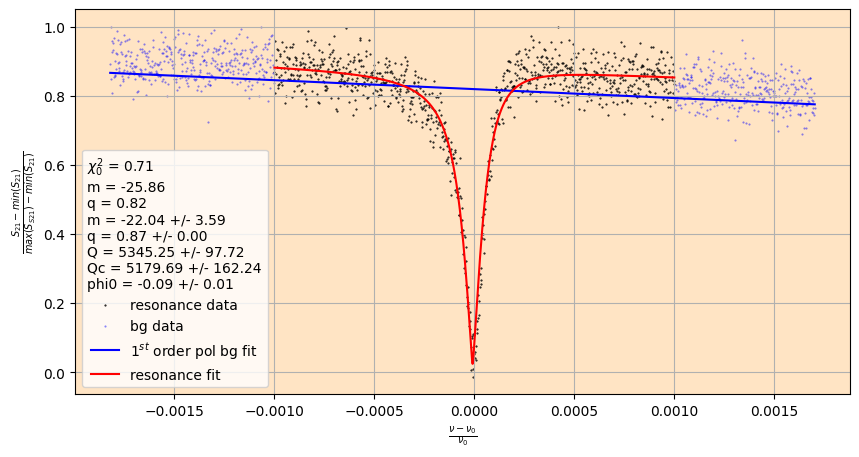

In [623]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
axs.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
axs.set_ylabel(r"$\frac{S_{21}-min(S_{21})}{max(S_{S21})-min(S_{21})}$")
axs.set_xlabel(r"$\frac{\nu-\nu_{0}}{\nu_{0}}$")
axs.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
axs.plot(F_res, model(F_res, *m.values), color='red',label='resonance fit')
axs.grid()

chi2 = m.fval
ndof = m.ndof

title = [r"$\chi_{0}^2$ = "+f"{chi2/ndof:.2f}", f"m = {params[0]:.2f}", f"q = {params[1]:.2f}"]
for par in m.parameters:
            title.append(
                f"{par} = {m.values[par]:.2f} +/- {m.errors[par]:.2f}"
            )
axs.legend(title = "\n".join(title))
axs.set_facecolor('bisque')